In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #print(img)
    #print(color_space, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #print(file)
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        file_features = single_img_features(image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), scale = 1.5):
#     if scale != 1:
#         imshape = ctrans_tosearch.shape
#         ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    #print("slide_window {}".format(len(window_list)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Read in our vehicles and non-vehicles
images = glob.glob('./data/*/*/*.png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image :
        notcars.append(image)
    else:
        cars.append(image)

print("length car", len(cars))
print("length non-car", len(notcars))

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
# ystart = 400
# ystop = 656
# scale = 1.5


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

length car 8807
length non-car 9020


/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [ ]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

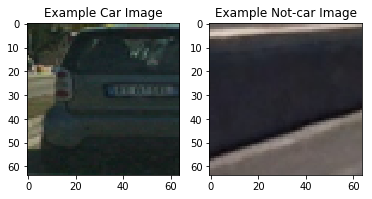

In [5]:
%matplotlib inline
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [6]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
print(ind)

5468


/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


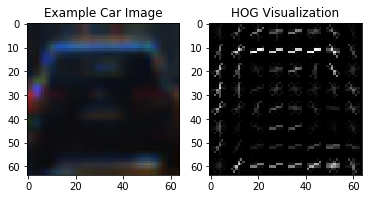

In [7]:
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


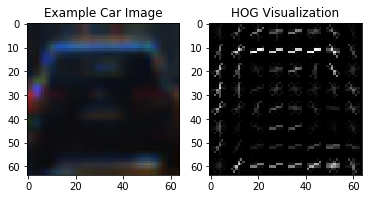

In [8]:

ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(ycrcb[:,:,0], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


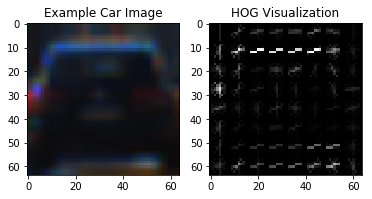

In [9]:

rgb = image

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(rgb[:,:,2], orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [ ]:
import pickle
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat 
dist_pickle["hog_feat"] = hog_feat
dist_pickle["y_start_stop"]  = y_start_stop
pickle.dump( dist_pickle, open( "svc_pickle_sub1.p", "wb" ) )

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
#from lesson_functions import *

dist_pickle = pickle.load( open("svc_pickle_sub1.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat  = dist_pickle["hist_feat"] 
hog_feat = dist_pickle["hog_feat"] 
y_start_stop = dist_pickle["y_start_stop"] 

print(orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, y_start_stop)

9 8 2 (32, 32) 32 True True True [400, 656]


In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    i = 0
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        filename = "./data/video/{}.png".format(i)
        i += 1
        #mpimg.imsave(filename, test_img, format='png')
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [29]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def heat_pipe(frame, box_list, threshold = 1):
    heat_zero = np.zeros_like(frame[:,:,0]).astype(np.float32)
    # Add heat to each box in box list
    orig_heat = add_heat(np.copy(heat_zero), box_list)
    # Apply threshold to help remove false positives
    heat_cap = apply_threshold(orig_heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_cap, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #plt.imshow(heat_zero)
    return labels, heatmap


In [31]:

%matplotlib inline
image = mpimg.imread('./orig_frames/images487.jpg')
draw_image = np.copy(image)
hot_windows = find_windows(image, cfg, scale255 = True)
labels, heat = heat_pipe(image, hot_windows, 2)
window_img = draw_labeled_bboxes(draw_image, labels)                    
boxed_image = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=2)
mpimg.imsave('./examples1/heat.jpg', heat)

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


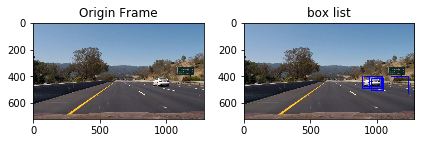

In [26]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Origin Frame')
plt.subplot(122)
plt.imshow(boxed_image, cmap='hot')
plt.title('box list')
fig.tight_layout()

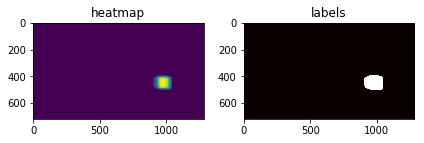

In [27]:

fig = plt.figure()
plt.subplot(121)
plt.imshow(heat)
plt.title('heatmap')
plt.subplot(122)
plt.imshow(labels[0], cmap='hot')
plt.title('labels')
fig.tight_layout()

In [33]:
image = mpimg.imread('./test_images/test1.jpg')
draw_image = np.copy(image)
hot_windows = find_windows(image, cfg, scale255 = True)
labels, heat = heat_pipe(image, hot_windows, 2)
window_img = draw_labeled_bboxes(draw_image, labels)                    
boxed_image = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=2)
mpimg.imsave('./examples1/test1.jpg', heat)

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


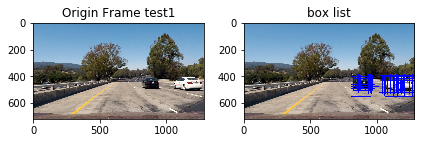

In [34]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Origin Frame test1')
plt.subplot(122)
plt.imshow(boxed_image, cmap='hot')
plt.title('box list')
fig.tight_layout()

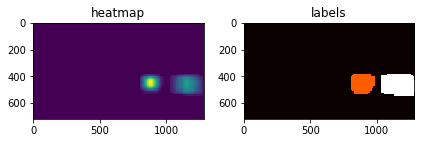

In [35]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(heat)
plt.title('heatmap')
plt.subplot(122)
plt.imshow(labels[0], cmap='hot')
plt.title('labels')
fig.tight_layout()

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


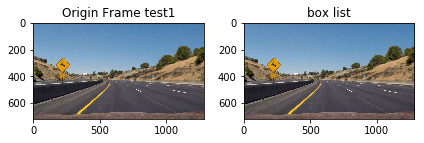

In [36]:
image = mpimg.imread('./test_images/test2.jpg')
draw_image = np.copy(image)
hot_windows = find_windows(image, cfg, scale255 = True)
labels, heat = heat_pipe(image, hot_windows, 2)
window_img = draw_labeled_bboxes(draw_image, labels)                    
boxed_image = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=2)
mpimg.imsave('./examples1/test1.jpg', heat)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Origin Frame test1')
plt.subplot(122)
plt.imshow(boxed_image, cmap='hot')
plt.title('box list')
fig.tight_layout()

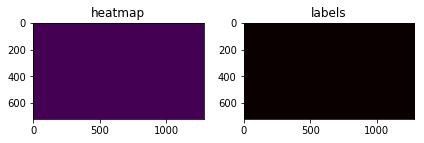

In [37]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(heat)
plt.title('heatmap')
plt.subplot(122)
plt.imshow(labels[0], cmap='hot')
plt.title('labels')
fig.tight_layout()

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


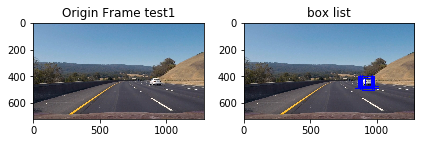

In [38]:
image = mpimg.imread('./test_images/test3.jpg')
draw_image = np.copy(image)
hot_windows = find_windows(image, cfg, scale255 = True)
labels, heat = heat_pipe(image, hot_windows, 2)
window_img = draw_labeled_bboxes(draw_image, labels)                    
boxed_image = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=2)
mpimg.imsave('./examples1/test1.jpg', heat)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Origin Frame test1')
plt.subplot(122)
plt.imshow(boxed_image, cmap='hot')
plt.title('box list')
fig.tight_layout()

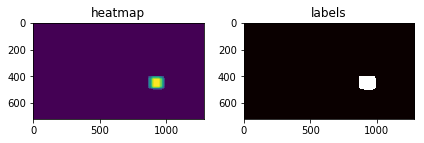

In [39]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(heat)
plt.title('heatmap')
plt.subplot(122)
plt.imshow(labels[0], cmap='hot')
plt.title('labels')
fig.tight_layout()

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


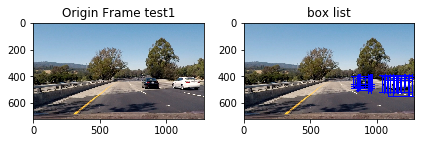

In [40]:
image = mpimg.imread('./test_images/test4.jpg')
draw_image = np.copy(image)
hot_windows = find_windows(image, cfg, scale255 = True)
labels, heat = heat_pipe(image, hot_windows, 2)
window_img = draw_labeled_bboxes(draw_image, labels)                    
boxed_image = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=2)
mpimg.imsave('./examples1/test1.jpg', heat)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Origin Frame test1')
plt.subplot(122)
plt.imshow(boxed_image, cmap='hot')
plt.title('box list')
fig.tight_layout()

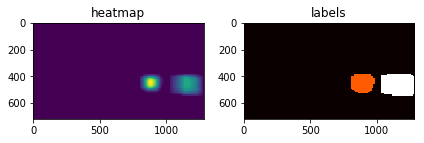

In [41]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(heat)
plt.title('heatmap')
plt.subplot(122)
plt.imshow(labels[0], cmap='hot')
plt.title('labels')
fig.tight_layout()

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


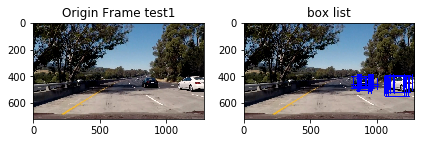

In [42]:
image = mpimg.imread('./test_images/test5.jpg')
draw_image = np.copy(image)
hot_windows = find_windows(image, cfg, scale255 = True)
labels, heat = heat_pipe(image, hot_windows, 2)
window_img = draw_labeled_bboxes(draw_image, labels)                    
boxed_image = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=2)
mpimg.imsave('./examples1/test1.jpg', heat)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Origin Frame test1')
plt.subplot(122)
plt.imshow(boxed_image, cmap='hot')
plt.title('box list')
fig.tight_layout()

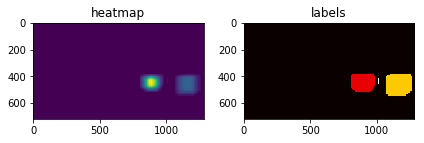

In [43]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(heat)
plt.title('heatmap')
plt.subplot(122)
plt.imshow(labels[0], cmap='hot')
plt.title('labels')
fig.tight_layout()

/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


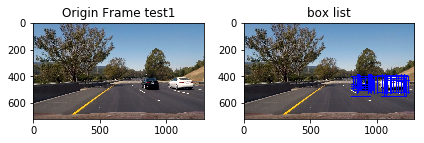

In [44]:
image = mpimg.imread('./test_images/test6.jpg')
draw_image = np.copy(image)
hot_windows = find_windows(image, cfg, scale255 = True)
labels, heat = heat_pipe(image, hot_windows, 2)
window_img = draw_labeled_bboxes(draw_image, labels)                    
boxed_image = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=2)
mpimg.imsave('./examples1/test1.jpg', heat)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Origin Frame test1')
plt.subplot(122)
plt.imshow(boxed_image, cmap='hot')
plt.title('box list')
fig.tight_layout()

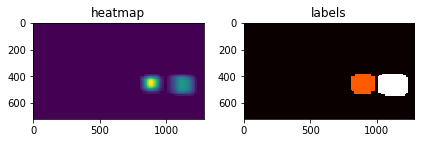

In [45]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(heat)
plt.title('heatmap')
plt.subplot(122)
plt.imshow(labels[0], cmap='hot')
plt.title('labels')
fig.tight_layout()

In [14]:
class Config_Parameters():
    def __init__(self):
        self.svc = None
        self.X_scaler = None
        self.color_space = "YCrCb"
        self.spatial_size = (32, 32)
        self.hist_bins = 32
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = "ALL"
        self.spatial_feat = True
        self.hist_feat = True
        self.hog_feat = True
        self.windows_64p = True
        self.windows_90p = True
        self.windows_120p = True
        self.heat_threshold = 1
        self.x_start_stop = [None, None]
        self.y_start_stop = [380, 656]
    

In [15]:
cfg = Config_Parameters()
cfg.svc = svc
cfg.X_scaler = X_scaler

In [48]:
# this function mainly define where to search the window for cars. 
# mostly focus on the right side of car for the computation purpose since the video has no
# car on left. it certainly can covers from x_start_stop =[None, None]
# the strategy used here is for the view far from driver, use small xy_window size, such as:
# (64, 64), (90, 90) and smaller overlap such as 0.7 or 0.8
# for the view are close to driver car, use large window size such as (90, 90), (130,130) and (150, 150)
# the overlap uses bigger overlap so that car can be detect mutiple times. The heat threshold > 1 will not mask off 
# the big car.
# more area is in between x_start_stop[700, 1050] for car is small.
# x_start_stop[1000, None] for closer car appears bigger on.


def find_windows(image, cfg, scale255 = True,) :
    if scale255 : 
        image = image.astype(np.float32)/255

    windows_1 = slide_window(image, x_start_stop=[700, None], y_start_stop=y_start_stop, 
                                   xy_window=(64, 64), xy_overlap=(0.7, 0.7))
    
    windows_2 = slide_window(image, x_start_stop=[700, 1050], y_start_stop=y_start_stop, 
                                   xy_window=(90, 90), xy_overlap=(0.8, 0.8))
        
    windows_3 = slide_window(image, x_start_stop=[800, 1050], y_start_stop=[380, 550], 
                                   xy_window=(90, 90), xy_overlap=(0.9, 0.9))    
    
    windows_4 = slide_window(image, x_start_stop=[800, None], y_start_stop=y_start_stop, 
                                    xy_window=(130, 130), xy_overlap=(0.8, 0.8))
    
    windows_5 = slide_window(image, x_start_stop=[800, 1050], y_start_stop=[380,500], 
                                    xy_window=(150, 80), xy_overlap=(0.8, 0.8))

    windows_6 = slide_window(image, x_start_stop=[800, None], y_start_stop=y_start_stop, 
                                    xy_window=(150, 150), xy_overlap=(0.9, 0.9))

    windows_7 = slide_window(image, x_start_stop=[1000, None], y_start_stop=[380,600], 
                                    xy_window=(90, 90), xy_overlap=(0.8, 0.8))


    windows_8 = slide_window(image, x_start_stop=[1000, None], y_start_stop=[380,600], 
                                    xy_window=(130, 130), xy_overlap=(0.9, 0.9))


    windows = windows_1 + windows_2 + \
              windows_3 + windows_4 + \
              windows_5 + windows_6 + \
              windows_7 + windows_8
    
    hot_windows = search_windows(image, windows, cfg.svc, cfg.X_scaler, color_space=cfg.color_space, 
                        spatial_size=cfg.spatial_size, hist_bins=cfg.hist_bins, 
                        orient=cfg.orient, pix_per_cell=cfg.pix_per_cell, 
                        cell_per_block=cfg.cell_per_block, 
                        hog_channel=cfg.hog_channel, spatial_feat=cfg.spatial_feat, 
                        hist_feat=cfg.hist_feat, hog_feat=cfg.hog_feat)  
    return hot_windows, windows

In [51]:
def find_windows1(image, cfg, scale255 = True,) :
    if scale255 : 
        image = image.astype(np.float32)/255

    windows_1 = slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                                   xy_window=(64, 64), xy_overlap=(0.7, 0.7))
    
    windows_2 = slide_window(image, x_start_stop=[400, 1050], y_start_stop=y_start_stop, 
                                   xy_window=(90, 90), xy_overlap=(0.8, 0.8))
        
    windows_3 = slide_window(image, x_start_stop=[400, 1050], y_start_stop=[380, 550], 
                                   xy_window=(90, 90), xy_overlap=(0.9, 0.9))    
    
    windows_4 = slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                                    xy_window=(130, 130), xy_overlap=(0.8, 0.8))
    
    windows_5 = slide_window(image, x_start_stop=[400, 1050], y_start_stop=[380,500], 
                                    xy_window=(150, 80), xy_overlap=(0.8, 0.8))

    windows_6 = slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                                    xy_window=(150, 150), xy_overlap=(0.9, 0.9))

    windows_7 = slide_window(image, x_start_stop=[400, None], y_start_stop=[380,600], 
                                    xy_window=(90, 90), xy_overlap=(0.8, 0.8))


    windows_8 = slide_window(image, x_start_stop=[400, None], y_start_stop=[380,600], 
                                    xy_window=(130, 130), xy_overlap=(0.9, 0.9))


    windows = windows_1 + windows_2 + \
              windows_3 + windows_4 + \
              windows_5 + windows_6 + \
              windows_7 + windows_8
    
    hot_windows = search_windows(image, windows, cfg.svc, cfg.X_scaler, color_space=cfg.color_space, 
                        spatial_size=cfg.spatial_size, hist_bins=cfg.hist_bins, 
                        orient=cfg.orient, pix_per_cell=cfg.pix_per_cell, 
                        cell_per_block=cfg.cell_per_block, 
                        hog_channel=cfg.hog_channel, spatial_feat=cfg.spatial_feat, 
                        hist_feat=cfg.hist_feat, hog_feat=cfg.hog_feat)  
    return hot_windows, windows

In [17]:

# this function first call the find_windows which returns the boxes identified card in it.
# then use the heat map to filter the false positive and group all neighbouring to single box.
def find_car_in_image(frame, cfg, scale255 = True, heat_threshold = 0):
    draw_image = np.copy(frame)
    hot_windows, windows = find_windows(frame, cfg, scale255 = True)
    #print(hot_windows)
    labels, heat = heat_pipe(image, hot_windows, heat_threshold)
    window_img = draw_labeled_bboxes(draw_image, labels)                    

    return window_img




/Users/dad/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


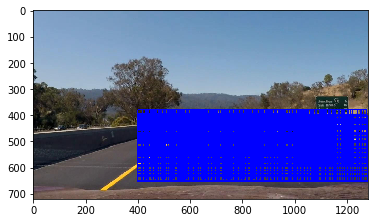

In [52]:
image = mpimg.imread('./orig_frames/images487.jpg')
draw_image = np.copy(image)
hot_windows, windows = find_windows1(image, cfg, scale255 = True)
boxed_image = draw_boxes(image, windows, color=(0, 0, 255), thick=2)

#image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(boxed_image)

In [ ]:
%matplotlib inline
image = mpimg.imread('./orig_frames/images484.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
%matplotlib inline
image = mpimg.imread('./orig_frames/images1009.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
%matplotlib inline
image = mpimg.imread('./orig_frames/images1041.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
image = mpimg.imread('./orig_frames/images655.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
images = []
import os
orig_frame_out = './orig_frames/'
#orig_frame_out = './samples/'
print(orig_frame_out)
output_frame = './frames_out1_heat1_no_150p/'
files = os.listdir(orig_frame_out)

#for i in range(len(files)):
#for i in range(500, 520) : #len(files)):
#for i in range(482, 496) : #len(files)):
for i in range(0, len(files)):
    filename = '{}images{}.jpg'.format(orig_frame_out, i)
    my_frame = mpimg.imread(filename)
    my_frame = find_car_in_image(my_frame, cfg, scale255 = True, heat_threshold = 2)
    images.append(my_frame)
    
    my_frame = cv2.cvtColor(my_frame, cv2.COLOR_RGB2BGR)
    output_filename = output_frame + 'frame_{0:0>3}.jpg'.format(i)
    cv2.imwrite(output_filename, my_frame)
    
    if(i % 50 == 0 ) :
        print("processing frame", i)

print("done with video frames")

In [ ]:
import imageio

#imageio.plugins.ffmpeg.download()

from moviepy.editor import ImageSequenceClip


video_file = 'vehicle_detection_700_1.mp4'
print("Creating video {}, FPS={}".format(video_file, 30))
clip = ImageSequenceClip(images, fps=30)
clip.write_videofile(video_file)

In [ ]:
%matplotlib inline
image = mpimg.imread('./orig_frames/images953.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
cfg5 = Config_Parameters()
cfg5.svc = svc
cfg5.X_scaler = X_scaler

image = mpimg.imread('./test_images/test5.jpg')

image = find_car_in_image(image, cfg5, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
%matplotlib inline
image = mpimg.imread('./samples/images500.jpg')
#print(image)
image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
#print("cover", image)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.imshow(image)

In [ ]:
image = mpimg.imread('./test_images/test6.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
image = mpimg.imread('./test_images/test1.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
image = mpimg.imread('./test_images/test2.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
image = mpimg.imread('./test_images/test3.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
image = mpimg.imread('./test_images/test4.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
image = mpimg.imread('./orig_frames/images260.jpg')

image = find_car_in_image(image, cfg, scale255 = True, heat_threshold = 2)
plt.imshow(image)

In [ ]:
image = mpimg.imread('./orig_frames/images260.jpg')


In [ ]:
import imageio
from moviepy.editor import VideoFileClip, concatenate_videoclips
#imageio.plugins.ffmpeg.download()

from moviepy.editor import ImageSequenceClip


clip1 = VideoFileClip("vehicle_detection_heat2_f1_1.mp4")
clip2 = VideoFileClip("vehicle_detection_heat2_f2_1.mp4")
clip3 = VideoFileClip("vehicle_detection_heat2_f3_1.mp4")
clip4 = VideoFileClip("vehicle_detection_heat2_f4_1.mp4")
clip5 = VideoFileClip("vehicle_detection_heat2_f5_1.mp4")
clip6 = VideoFileClip("vehicle_detection_heat2_f6_1.mp4")
clip  = concatenate_videoclips([clip1, clip2 ,  clip3 , clip4 , clip5 , clip6])

clip.write_videofile("vehicle_detection_heat2_final_2.mp4")